In [37]:
import keras

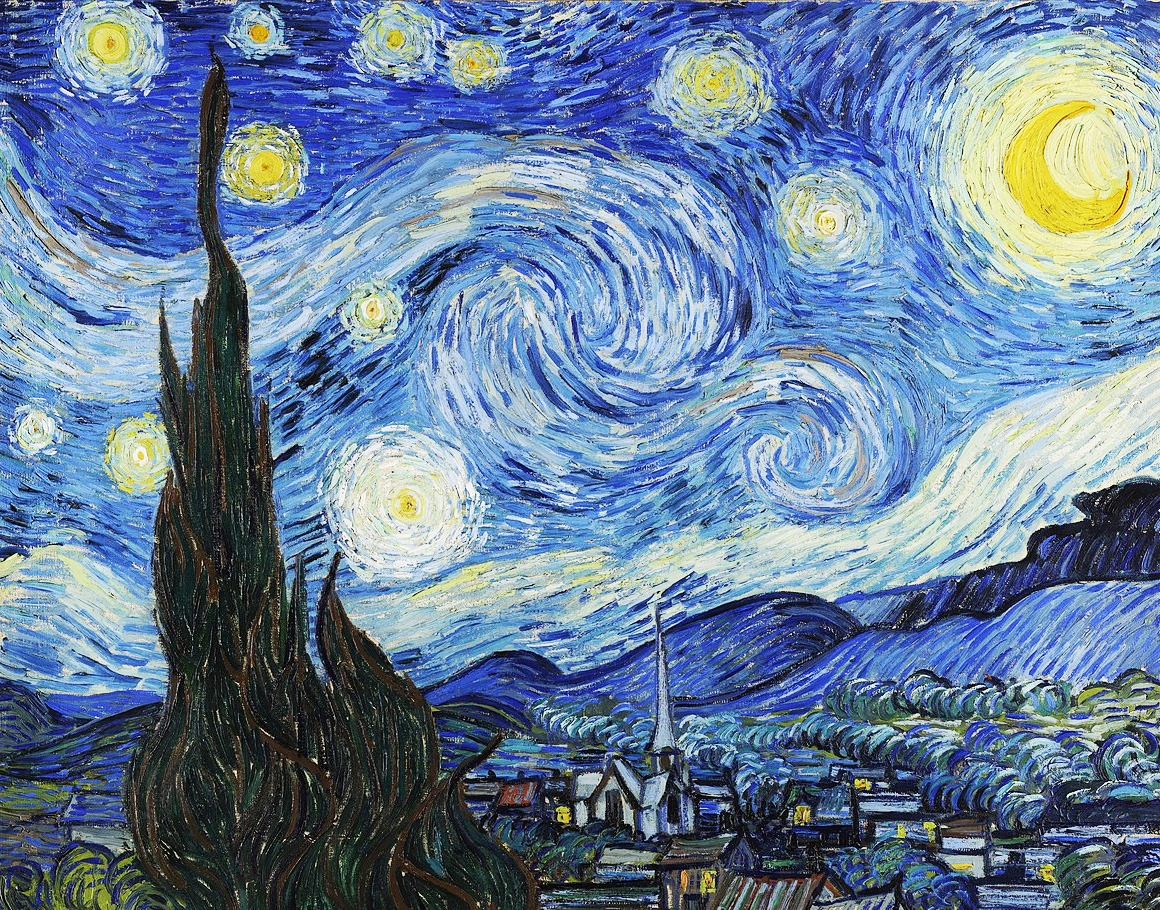

In [38]:
base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

orig_w, orig_h = keras.utils.load_img(base_image_path).size
img_h = 400
img_w = round(orig_w * img_h / orig_h)

keras.utils.load_img(base_image_path)
keras.utils.load_img(style_reference_image_path)


In [39]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_h, img_w))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_h, img_w, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [40]:
model = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)

outputs_dict = {layer.name: layer.output for layer in model.layers}

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [41]:
import tensorflow as tf

def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [42]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style_img, combination_img):
    gram_S = gram_matrix(style_img)
    gram_C = gram_matrix(combination_img)
    channels = 3
    size = img_h * img_w
    return tf.reduce_sum(tf.square(gram_S - gram_C)) / (4 * (channels ** 2) * (size ** 2))

gram_matrix(tf.random.normal(shape=(5, 4, 3)))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[13.509771 , -2.274215 ,  3.9068565],
       [-2.274215 , 18.84391  , -5.457108 ],
       [ 3.9068565, -5.457108 , 11.37678  ]], dtype=float32)>

In [43]:
def total_variation_loss(x):
    a = tf.square(
        x[:, :(img_h - 1), :(img_w - 1), :] - x[:, 1:, :(img_w - 1), :]
    )
    b = tf.square(
        x[:, :(img_h - 1), :(img_w - 1), :] - x[:, :(img_h - 1), 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

total_variation_loss(tf.random.uniform(shape=(1, img_h, img_w, 3)))

<tf.Tensor: shape=(), dtype=float32, numpy=179621.75>

In [44]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([
        base_image, style_reference_image, combination_image
        ], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    content_layer_features = features[content_layer_name]
    base_image_content_features = content_layer_features[0, :, :, :]
    combination_image_content_features = content_layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_img=base_image_content_features,
        combination_img=combination_image_content_features)
    
    for layer_name in style_layer_names:
        layer_style_features = features[layer_name]
        style_reference_style_features = layer_style_features[1, :, :, :]
        combination_image_style_features = layer_style_features[2, :, :, :]
        style_loss_value = style_loss(
            style_reference_style_features,
            combination_image_style_features
        )
        loss += style_weight / len(style_layer_names) * style_loss_value
    
    loss += total_variation_weight * total_variation_loss(combination_image)
    
    return loss

In [45]:
@tf.function
def compute_loss_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            combination_image=combination_image,
            base_image=base_image,
            style_reference_image=style_reference_image)
        grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

n_iter = 4000
for i in range(1, n_iter + 1):
    loss, grads = compute_loss_grads(
        combination_image=combination_image,
        base_image=base_image,
        style_reference_image=style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f'Iteration {i}: loss={loss:.2f}')
        img = deprocess_image(combination_image.numpy())
        filename = f'combination_image_at_iteration_{i}.png'
        keras.utils.save_img(filename, img)
